#  Прогнозирование заказов такси

Заказчик - сервис заказа такси. На исторических данных о заказах такси в аэропортах для привлечения большего количества водителей в пиковый период нагрузки необходимо построить модель для прогнозирования количества заказов такси в следующий час.

Ключевая метрика на тестовой выборке - *RMSE*.

**Ход работы**:

1. Загрузка данных и их ресемплирование.
2. Анализ данные.
3. Обучение моделей.
4. Проверка данных на тестовой выборке.
5. Выводы

## Подготовка

In [1]:
# загружаю необходимые библиотеку
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


In [2]:
# загружаю данные
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data)

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]

In [3]:
print(data.isna().sum())

num_orders    0
dtype: int64


In [4]:
# проверяю монотонность индекса
print(data.index.is_monotonic)

True


In [5]:
# ресемплирую по каждому часу, результат - среднее значение 
data = data.resample('1H').sum()
display(data)

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

In [6]:
print(data.head())
print(data.tail())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
                     num_orders
datetime                       
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205


In [7]:
data.isna().sum()

num_orders    0
dtype: int64

## Анализ

### Скользящее среднее

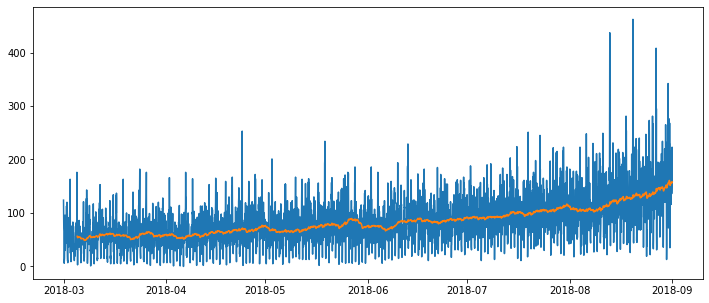

In [8]:
# нахожу скользящее среднее 
data['rolling_mean'] = data.rolling(100).mean()
plt.figure(figsize=(12, 5))
plt.plot(data)
plt.show()

### Тренд, сезонность, остатки

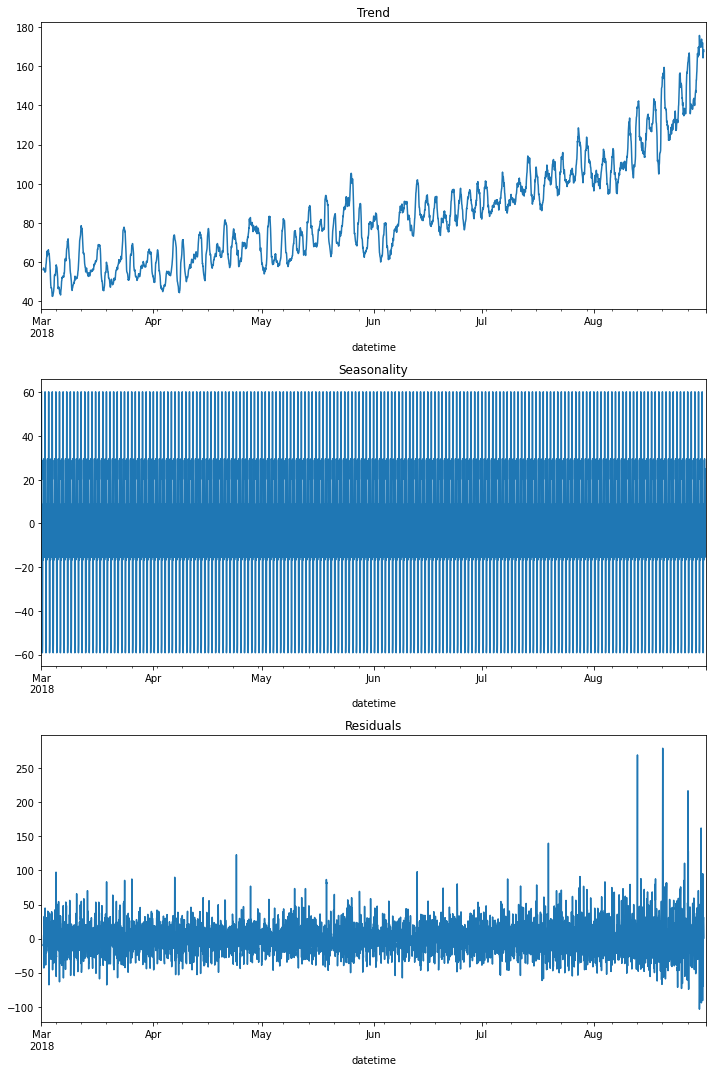

In [9]:
# определяю тренд, сезонность и остатки временного ряда
decomposed = seasonal_decompose(data.drop('rolling_mean', axis=1))


plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
print()

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
print()

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Тренд:** по графику видно, что с начала марта к концу лета постепенно растут значения. Возможно, это связано с тем, что июль-август, особенно конец августа - самые благоприятные для отдыха месяцы, в которые люди активно путешествуют, а значит пользуются аэропортами и услугами такси.

**Сезонность:** период - треть месяца - 10 дней. Так как сезонность не понятна, попробую ресемплировать по 1 дню и рассмотреть только 1 месяц.

**Остатки:** не объяснимы.

In [10]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df = df.resample('1H').sum()
#df = df['2018-03-01':'2018-03-5']
display(df)

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

Text(0.5, 1.0, 'Seasonality')

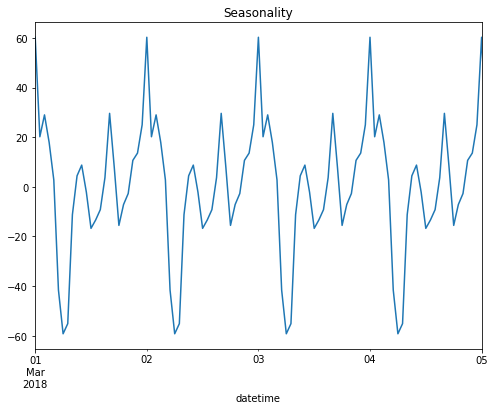

In [20]:
df_decomposed = seasonal_decompose(df)

plt.figure(figsize=(8, 6))
df_decomposed.seasonal.plot(ax=plt.gca())
plt.xlim(['2018-03-01','2018-03-5'])
plt.title('Seasonality')

**Сезонность:** при более подробном рассмотрении видим сезонность, равную 1 дню. Пик приходитмя на начало суток (00.00), к утру падает, а к ночи вновь набирает рост. Возможно, людям проще добираться днем самостоятельно, чем ночью, и ночью они прибегают к помощи такси

### Стационарность ряда

In [21]:
# стационарность ряда
data['rolling_std'] = data['num_orders'].rolling(100).std()
display(data)

num_orders  rolling_mean  rolling_std
datetime                                                  
2018-03-01 00:00:00         124           NaN          NaN
2018-03-01 01:00:00          85           NaN          NaN
2018-03-01 02:00:00          71           NaN          NaN
2018-03-01 03:00:00          66           NaN          NaN
2018-03-01 04:00:00          43           NaN          NaN
...                         ...           ...          ...
2018-08-31 19:00:00         136        156.74    58.703952
2018-08-31 20:00:00         154        156.63    58.698623
2018-08-31 21:00:00         159        156.40    58.643246
2018-08-31 22:00:00         223        157.52    58.836613
2018-08-31 23:00:00         205        158.05    59.024798

[4416 rows x 3 columns]

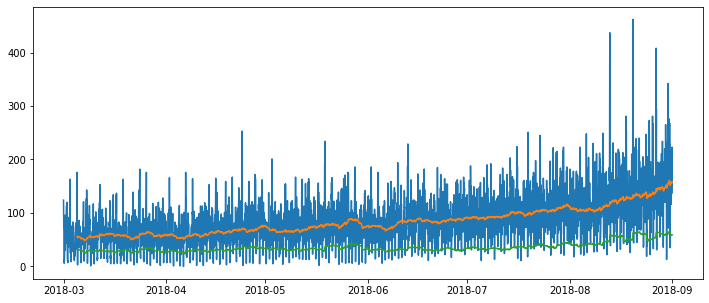

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(data)
plt.show()

**Cтационарные** временные ряды  — это ряды, у которых среднее и стандартное отклонение не меняются. Так как и среднее значение, и стандартное отклонение у временного ряда меняется, следовательно, данный ряд нельзя назвать стационарным.

### Разности временного ряда

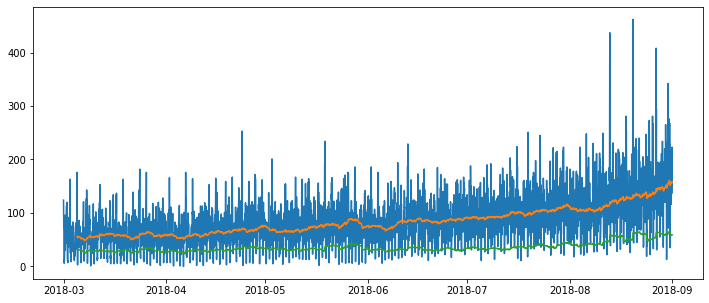

In [23]:
data1 = data - data.shift()
data1['mean'] = data1['num_orders'].rolling(100).mean()
data1['std'] = data1['num_orders'].rolling(100).std()
plt.figure(figsize=(12, 5))
plt.plot(data)
plt.show()

И до преобразования, и после временный ряд не сильно изменился, он по-прежнему линейный.

## Обучение

In [24]:
df = data.drop(['rolling_mean', 'rolling_std'], axis=1)
display(df)

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

### Создание признаков

In [26]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 24, 6)
display(df.head())

num_orders  year  month  day  dayofweek  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124  2018      3    1          3    NaN    NaN   
2018-03-01 01:00:00          85  2018      3    1          3  124.0    NaN   
2018-03-01 02:00:00          71  2018      3    1          3   85.0  124.0   
2018-03-01 03:00:00          66  2018      3    1          3   71.0   85.0   
2018-03-01 04:00:00          43  2018      3    1          3   66.0   71.0   

                     lag_3  lag_4  lag_5  ...  lag_15  lag_16  lag_17  lag_18  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00  124.0    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 04:00:00   85.0  124.0    NaN  ...     NaN     NaN     NaN     NaN   

                     lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  
datetime                                                             
2018-03-01 00:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 02:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 03:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 04:00:00     NaN     NaN     NaN     NaN     NaN     NaN  

[5 rows x 30 columns]

### Разделение данных на тренировочную и тестовую выборки

In [27]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

print(df.shape)
print(train.shape)
print(test.shape)
print()
display(train.tail(1))
display(test.head(1))

(4416, 30)
(3950, 30)
(442, 30)



num_orders  year  month  day  dayofweek  lag_1  lag_2  \
datetime                                                                     
2018-08-13 13:00:00         119  2018      8   13          0   92.0  144.0   

                     lag_3  lag_4  lag_5  ...  lag_15  lag_16  lag_17  lag_18  \
datetime                                  ...                                   
2018-08-13 13:00:00  156.0  137.0   91.0  ...   118.0   135.0    98.0    82.0   

                     lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  
datetime                                                             
2018-08-13 13:00:00    78.0   115.0   153.0   149.0   104.0   120.0  

[1 rows x 30 columns]

num_orders  year  month  day  dayofweek  lag_1  lag_2  \
datetime                                                                     
2018-08-13 14:00:00         102  2018      8   13          0  119.0   92.0   

                     lag_3  lag_4  lag_5  ...  lag_15  lag_16  lag_17  lag_18  \
datetime                                  ...                                   
2018-08-13 14:00:00  144.0  156.0  137.0  ...   185.0   118.0   135.0    98.0   

                     lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  
datetime                                                             
2018-08-13 14:00:00    82.0    78.0   115.0   153.0   149.0   104.0  

[1 rows x 30 columns]

Выборки идут четко друг за другом по временным промежуткам, следовательно, можно обучать модели.

In [28]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3950, 29)
(3950,)
(442, 29)
(442,)


### Линейная регрессия

In [29]:
linear = LinearRegression()
cv = TimeSeriesSplit(n_splits=5)
linear_scores = cross_val_score(linear, features_train, target_train, scoring = 'neg_mean_squared_error', cv=cv)
linear_mse = sum( (-1)*linear_scores ) / len(linear_scores)
linear_rmse = linear_mse ** 0.5
print('linear rmse =', linear_rmse)

linear rmse = 27.22317082526746


RMSE обучающей выборки равно linear rmse = 27.22317082526746

###  Случайный лес

In [30]:
# определяю количество деревьев и максимальную глубину
best_result = 10000
best_est = 0
best_depth = 0

for est in range(10,101,10):
    for depth in range(1,20):
        forest = RandomForestRegressor(random_state=42, n_estimators=est, max_depth=depth)
        cv = TimeSeriesSplit(n_splits=5)
        forest_scores = cross_val_score(forest, features_train, target_train, scoring = 'neg_mean_squared_error', cv=cv)
        forest_mse = sum( (-1)*forest_scores ) / len(forest_scores)
        forest_rmse = forest_mse ** 0.5
        if forest_rmse < best_result:
            best_result = forest_rmse
            best_est = est
            best_depth = depth
print()
print('RMSE обучающей выборки:', best_result, 'достигается при количестве деревьев', best_est, 'и глубине', depth)


RMSE обучающей выборки: 26.008007011140453 достигается при количестве деревьев 100 и глубине 19


RMSE обучающей выборки: 26.008007011140453 достигается при количестве деревьев 100 и глубине 19

###  Дерево решений

In [31]:
# определяю максимальную глубину
best_result = 10000
best_depth = 0

for depth in range(1,51):
    tree = DecisionTreeRegressor(random_state=42, max_depth=depth)
    cv = TimeSeriesSplit(n_splits=5)
    tree_scores = cross_val_score(tree, features_train, target_train, scoring = 'neg_mean_squared_error', cv=cv)
    tree_mse = sum( (-1)*tree_scores ) / len(tree_scores)
    tree_rmse = tree_mse ** 0.5
    if tree_rmse < best_result:
        best_result = tree_rmse
        best_depth = depth
print()
print('RMSE обучающей выборки', best_result, 'достигается при глубине глубине', depth)


RMSE обучающей выборки 29.771705980617174 достигается при глубине глубине 50


RMSE обучающей выборки 29.771705980617174 достигается при глубине глубине 50

###  Градиентный бустинг catboost

In [32]:
best_result = 10000
best_iteration = 0

for iteration in range(1,1001,100):
    catboost = CatBoostRegressor(iterations=iteration, learning_rate=1,depth=2)
    cv = TimeSeriesSplit(n_splits=5)
    catboost_scores = cross_val_score(catboost, features_train, target_train, scoring = 'neg_mean_squared_error', cv=cv)
    catboost_mse = sum( (-1)*catboost_scores ) / len(catboost_scores)
    catboost_rmse = catboost_mse ** 0.5
    if catboost_rmse < best_result:
        best_result = catboost_rmse
        best_iteration = iteration
print()
print('RMSE обучающей выборки:', best_result, 'достигается при количестве итераций', iteration)

0:	learn: 22.6708672	total: 47.4ms	remaining: 0us
0:	learn: 24.3396464	total: 1.16ms	remaining: 0us
0:	learn: 26.1527189	total: 1.41ms	remaining: 0us
0:	learn: 26.7851128	total: 1.6ms	remaining: 0us
0:	learn: 27.7750954	total: 1.74ms	remaining: 0us
0:	learn: 22.6708672	total: 835us	remaining: 83.6ms
1:	learn: 21.4646586	total: 1.69ms	remaining: 83.9ms
2:	learn: 20.9663617	total: 2.32ms	remaining: 75.8ms
3:	learn: 20.5581501	total: 3.02ms	remaining: 73.3ms
4:	learn: 20.1941499	total: 3.67ms	remaining: 70.5ms
5:	learn: 19.5024924	total: 4.31ms	remaining: 68.2ms
6:	learn: 19.0333700	total: 4.93ms	remaining: 66.2ms
7:	learn: 18.7304981	total: 5.55ms	remaining: 64.5ms
8:	learn: 18.4767724	total: 6.7ms	remaining: 68.5ms
9:	learn: 18.2263076	total: 7.68ms	remaining: 69.9ms
10:	learn: 17.6906992	total: 8.69ms	remaining: 71.1ms
11:	learn: 17.4525522	total: 9.74ms	remaining: 72.2ms
12:	learn: 17.1159031	total: 10.7ms	remaining: 72.5ms
13:	learn: 16.8041743	total: 11.7ms	remaining: 72.4ms
14:	lea

RMSE обучающей выборки: 29.362294483784524 достигается при количестве итераций 901

In [33]:
# перебераю теперь глубину
best_result = 10000
best_depth = 0

for depth in range(1,11):
    catboost = CatBoostRegressor(iterations=901, learning_rate=1,depth=depth)
    cv = TimeSeriesSplit(n_splits=5)
    catboost_scores = cross_val_score(catboost, features_train, target_train, scoring = 'neg_mean_squared_error', cv=cv)
    catboost_mse = sum( (-1)*catboost_scores ) / len(catboost_scores)
    catboost_rmse = catboost_mse ** 0.5
    if catboost_rmse < best_result:
        best_result = catboost_rmse
        best_depth = depth
print()
print('RMSE обучающей выборки:', best_result, 'достигается при количестве итераций', iteration, 'и глубине ', depth)

0:	learn: 25.3354300	total: 492us	remaining: 443ms
1:	learn: 23.2427318	total: 1.02ms	remaining: 459ms
2:	learn: 22.4169855	total: 1.45ms	remaining: 435ms
3:	learn: 22.1311719	total: 1.86ms	remaining: 416ms
4:	learn: 21.9915701	total: 2.28ms	remaining: 408ms
5:	learn: 21.9531257	total: 2.72ms	remaining: 406ms
6:	learn: 21.7206496	total: 3.14ms	remaining: 401ms
7:	learn: 21.1849308	total: 3.56ms	remaining: 398ms
8:	learn: 21.0147641	total: 4.02ms	remaining: 398ms
9:	learn: 20.7979066	total: 4.45ms	remaining: 396ms
10:	learn: 20.5806523	total: 4.87ms	remaining: 394ms
11:	learn: 20.4214510	total: 5.28ms	remaining: 391ms
12:	learn: 20.2810824	total: 5.74ms	remaining: 392ms
13:	learn: 20.0825480	total: 6.18ms	remaining: 391ms
14:	learn: 19.9963405	total: 6.6ms	remaining: 390ms
15:	learn: 19.8139800	total: 7.02ms	remaining: 388ms
16:	learn: 19.4835990	total: 7.44ms	remaining: 387ms
17:	learn: 19.3281296	total: 7.82ms	remaining: 384ms
18:	learn: 19.0814987	total: 8.26ms	remaining: 383ms
19:	l

RMSE обучающей выборки: 29.40988481535082 достигается при количестве итераций 901 и глубине  10

###  Градиентный бустинг ldbm

In [34]:
best_result = 10000
best_est = 0
for est in range(10,101,10):
    lgbm_model = LGBMRegressor(random_state=42, n_estimators=est)
    cv = TimeSeriesSplit(n_splits=5)
    lgbm_scores = cross_val_score(lgbm_model, features_train, target_train, scoring = 'neg_mean_squared_error', cv=cv)
    lgbm_mse = sum( (-1)*lgbm_scores ) / len(lgbm_scores)
    lgbm_rmse = lgbm_mse ** 0.5
    if lgbm_rmse < best_result:
        best_result = lgbm_rmse
        best_est = est
print()
print('RMSE обучающей выборки:', best_result, 'достигается при количестве деревьев', est)


RMSE обучающей выборки: 25.880052190612894 достигается при количестве деревьев 100


RMSE обучающей выборки: 25.880052190612894 достигается при количестве деревьев 100

## Тестирование

### Линейная регрессия

In [35]:
linear = LinearRegression()
linear.fit(features_train, target_train)
linear_predictions_test = linear.predict(features_test)
linear_test_mse = mean_squared_error(linear_predictions_test, target_test)
linear_test_rmse = linear_test_mse ** 0.5
print("linear RMSE тестовой выборки: ", linear_test_rmse)

linear RMSE тестовой выборки:  45.52933708020935


linear RMSE тестовой выборки:  45.52933708020935

### Случайный лес

In [36]:
forest = RandomForestRegressor(random_state=42, n_estimators=60, max_depth=19)
forest.fit(features_train, target_train)
forest_predictions_test = forest.predict(features_test)
forest_test_mse = mean_squared_error(forest_predictions_test, target_test)
forest_test_rmse = forest_test_mse ** 0.5
print("forest RMSE тестовой выборки: ", forest_test_rmse)

forest RMSE тестовой выборки:  42.64435024220032


forest RMSE тестовой выборки:  42.64435024220032

### Дерево решений

In [37]:
tree = DecisionTreeRegressor(random_state=42, max_depth=50)
tree.fit(features_train, target_train)
tree_predictions_test = tree.predict(features_test)
tree_test_mse = mean_squared_error(tree_predictions_test, target_test)
tree_test_rmse = tree_test_mse ** 0.5
print("tree RMSE тестовой выборки: ", tree_test_rmse)

tree RMSE тестовой выборки:  63.666285643202166


tree RMSE тестовой выборки:  63.666285643202166

### Градиентный бустинг catboost

In [38]:
catboost = CatBoostRegressor(iterations=901, learning_rate=1,depth=10)
catboost.fit(features_train, target_train)
catboost_predictions_test = catboost.predict(features_test)
catboost_test_mse = mean_squared_error(catboost_predictions_test, target_test)
catboost_test_rmse = catboost_test_mse ** 0.5
print("catboost RMSE тестовой выборки: ", catboost_test_rmse)

0:	learn: 27.7613682	total: 54.2ms	remaining: 48.8s
1:	learn: 25.2159922	total: 108ms	remaining: 48.6s
2:	learn: 24.5773906	total: 160ms	remaining: 47.9s
3:	learn: 22.4932159	total: 211ms	remaining: 47.4s
4:	learn: 21.3543689	total: 264ms	remaining: 47.3s
5:	learn: 20.2936362	total: 316ms	remaining: 47.2s
6:	learn: 19.2570688	total: 367ms	remaining: 46.9s
7:	learn: 18.1190669	total: 420ms	remaining: 46.9s
8:	learn: 17.3048431	total: 471ms	remaining: 46.7s
9:	learn: 16.6773401	total: 524ms	remaining: 46.7s
10:	learn: 16.6106166	total: 576ms	remaining: 46.6s
11:	learn: 15.8712930	total: 630ms	remaining: 46.7s
12:	learn: 15.2069573	total: 680ms	remaining: 46.5s
13:	learn: 14.1769176	total: 736ms	remaining: 46.7s
14:	learn: 13.5895065	total: 791ms	remaining: 46.7s
15:	learn: 13.0609155	total: 846ms	remaining: 46.8s
16:	learn: 12.6406178	total: 903ms	remaining: 47s
17:	learn: 12.0975891	total: 956ms	remaining: 46.9s
18:	learn: 11.5486211	total: 1.01s	remaining: 46.8s
19:	learn: 10.9958106	t

catboost RMSE тестовой выборки:  53.55514817446431

### Градиентный бустинг lgbm

In [39]:
lgbm_model = LGBMRegressor(random_state=42, n_estimators=100)
lgbm_model.fit(features_train, target_train)
lgbm_predictions_test = lgbm_model.predict(features_test)
lgbm_test_mse = mean_squared_error(lgbm_predictions_test, target_test)
lgbm_test_rmse = lgbm_test_mse ** 0.5
print("lgbm RMSE тестовой выборки: ", lgbm_test_rmse)

lgbm RMSE тестовой выборки:  41.84587197614543


lgbm RMSE тестовой выборки:  41.84587197614543

### Сравнение моделей

In [40]:
df_dict = {'model': ['tree', 'forest', 'linear', 'catboost', 'lgbm'], 
           'rmse': [tree_test_rmse, forest_test_rmse, linear_test_rmse, catboost_test_rmse, lgbm_test_rmse]
     }
df = pd.DataFrame(df_dict)
df = df.sort_values('rmse')
display(df)

model       rmse
4      lgbm  41.845872
1    forest  42.644350
2    linear  45.529337
3  catboost  53.555148
0      tree  63.666286

**Вывод:** Самые лучшие результаты показывает линейная регрессия

## Общий вывод

- Цель проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

- Полученные данные и их предобработка

Получен датасет, в котором указано количество заказов такси в каждые 10 минут времени. Было произведено ресемплирование по 1 часу, а в результате получена сумма заказов за каждые 10 минут в часе. Пропусков и дубликатов не обнаружено.

- Анализ

В анализе данных был построен график скользящего среднего.

**Тренд:** с начала марта к концу лета постепенно растут значения. Возможно, это связано с тем, что июль-август, особенно конец августа - самые благоприятные для отдыха месяцы, в которые люди активно путешествуют, а значит пользуются аэропортами и услугами такси.

**Сезонность** равна 1 дню. Пик приходитмя на начало суток (00.00), к утру падает, а к ночи вновь набирает рост. Возможно, людям проще добираться днем самостоятельно, чем ночью, и ночью они прибегают к помощи такси

**Остатки:** не объяснимы.

- Обучение

Датасет был поделен на обучающую и тестовую выборку, тестовая выборка составила 10% данных, тестовая следует сразу за обучающей, временные ряды сохранены.

С помощью кросс-валидации и параметра cv, равного TimeSeriesSplit(n_splits=5), были обучены 5 моделей:

        линейная регрессия (train_rmse = 31.71773426075703)
        случайный лес (лучшие гиперпараметры: n_estimators=100, max_depth=19; train_rmse  = 32.55887756275359)
        дерево решений (лучшие гиперпараметры: max_depth=50; train_rmse  = 33.61174026350504)
        градиентный бустинг catboost (лучшие гиперпараметры: iterations=901, max_depth=10; train_rmse  = 34.397337503433405)
        градиентный бустинг lgbm (лучшие гиперпараметры: n_estimators=100; train_rmse  = 32.708869474185036)
        
- Тестирование

Результаты rmse тестовой выборки 

    linear_rmse = 52.62032129288974

    forest_rmse = 54.8172913424075

    tree_rmse = 75.87608974818822

    catboost_rmse = 57.345425673425844

    lgbm_rmse = 53.192063843735646

- Общий вывод

    Самый лучшие результаты показывает линейная регрессия